In [1]:
## Tests detrending the activity time series

### load packages and set filepaths

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import date
import datetime
from pandas.plotting import register_matplotlib_converters

from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

register_matplotlib_converters()
sns.set_style("darkgrid")


In [2]:
import os
path = os.path.join("C:/","Users","u0084712","OneDrive - KU Leuven",
                    "projects","ugent","heatstress","datapreprocessing")
os.chdir(path)

plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

In [3]:
# path to data
path_data = os.path.join("C:/","Users","u0084712","OneDrive - KU Leuven",
                    "projects","ugent","heatstress","data")

# farm selected
farms = [6] #[30,31,33,34,35,38,39,40,43,44,45,46,47,48]


In [4]:
farm = 1

# read data
data = pd.read_csv(os.path.join(path_data, "act_" + str(farm) + ".txt"),
                       index_col=0)
data["measured_on"] = pd.to_datetime(data["measured_on"],format='%Y-%m-%d %H:%M:%S')
print(data["measured_on"].min())
data["farm_id"] = farm
data["date"] = data["measured_on"].dt.date
    
# delete data that has erroneous  dates
data = data.loc[data["date"] >= date(2005,1,1),:]
print("farm = " + str(farm) + ", startdate = " + str(data["measured_on"].min()))

# unique cows / cowids
cows = data["animal_id"].drop_duplicates().reset_index(drop=1)
cowlac = data[["animal_id","parity"]].drop_duplicates().sort_values(by=["parity","animal_id"]).reset_index(drop=1)
#print(cowlac)
    
# delete parity 0 (data before first calving) and data with NaN values
data = data.loc[data["activity_total"].isna()==False,:]
data = data.drop(data.loc[data["parity"]==0,:].index).reset_index(drop=1)
cowlac = data[["animal_id","parity"]].drop_duplicates().sort_values(by=["parity","animal_id"]).reset_index(drop=1)
#print(cowlac)

# aggregate data for activity per day
data = data.sort_values(by = ["animal_id","parity","measured_on"]).reset_index(drop=1)
# activity =  data[["animal_id","date","activity_total"]].groupby(by = ["animal_id","date"]).sum()
# activity = activity.rename(columns = {"activity_total" : "activity"})

"""
# remove data with summed activity > 1800 or smaller than 180
activity = activity.loc[(activity["activity"]<1800)&(activity["activity"]>180),:].reset_index(drop=1)
"""
  
# summarize and remove where too little data
activity_count = data[["animal_id","date","activity_total"]].fillna(-1).groupby(by = ["animal_id","date"]).count()
activity_sum = data[["animal_id","date","activity_total"]].fillna(-1).groupby(by = ["animal_id","date"]).sum()
activity_count["sum"] = activity_sum["activity_total"]
activity_count = activity_count.sort_values(by = "activity_total")
activity_count = activity_count.rename(columns = {"activity_total" : "count"})
del activity_sum
    
# select data along day-cow criteria
activity_count = activity_count.reset_index()
activity_count = activity_count.loc[(activity_count["sum"] >180) & \
                                    (activity_count["sum"] < 1800) & \
                                    (activity_count["count"] == 12),:].reset_index(drop=1)
#merge data and activity_count to select data with completeness
data = pd.merge(data,activity_count[["animal_id","date"]],how = "inner").reset_index(drop=1)
        
# dates where activity has too few data points different from nan (rumination only)
day_count = data[["date","activity_total"]].groupby(by = ["date"]).count().reset_index()
day_count["date"] = pd.to_datetime(day_count["date"],format='%Y-%m-%d')
day_count = day_count.loc[day_count["activity_total"] > 0,:]

# get daily activity
activity =  (
            data[["farm_id","animal_id","lactation_id","parity","date","activity_total"]]
            .groupby(by = ["farm_id","animal_id","lactation_id","parity","date"]).sum()
            .reset_index()
            )
activity = activity.rename(columns = {"activity_total" : "activity"})


2011-02-21 14:00:00
farm = 1, startdate = 2011-02-21 14:00:00


In [5]:
# trend data - averages per day over all cows
df = activity[["date","activity"]].groupby("date").mean()


In [6]:
mstl = MSTL(df["activity"], periods=[365,7], stl_kwargs = {"robust:"True})
res = mstl.fit()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (490687421.py, line 1)

In [ ]:
res.seasonal.head()

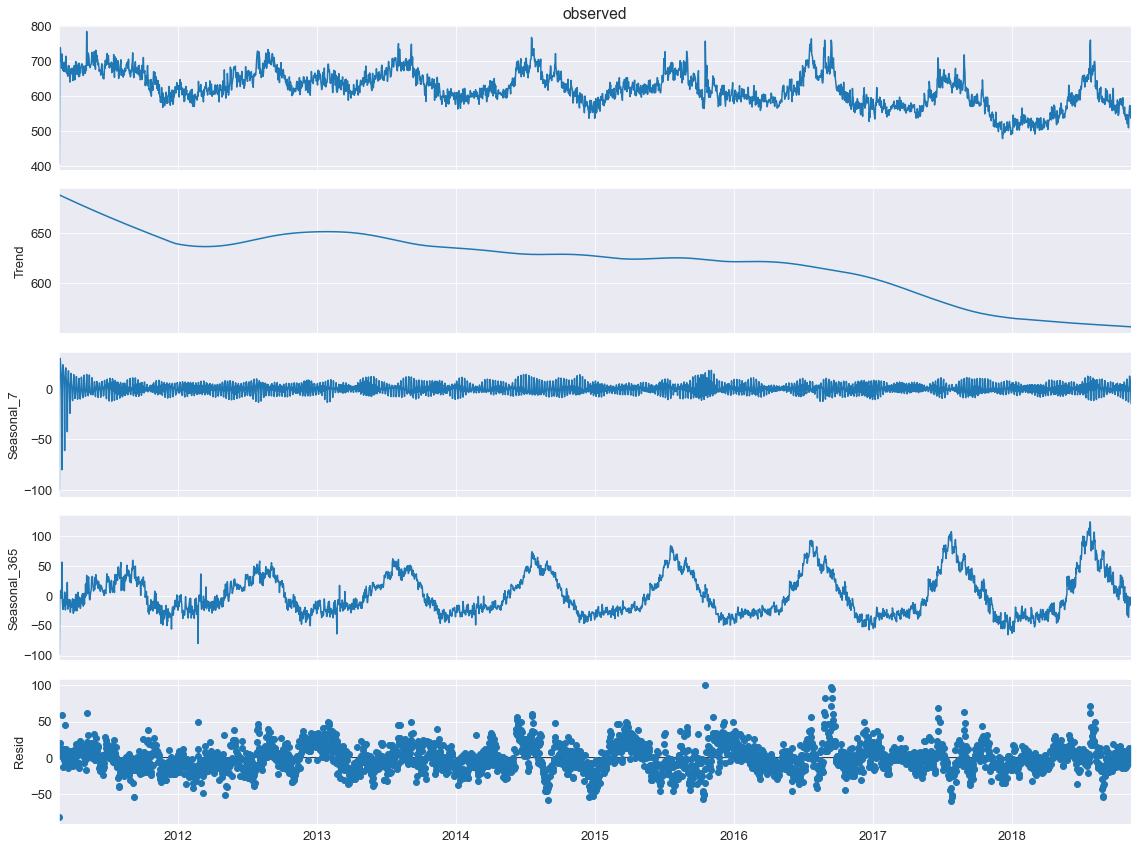

In [34]:
ax = res.plot()

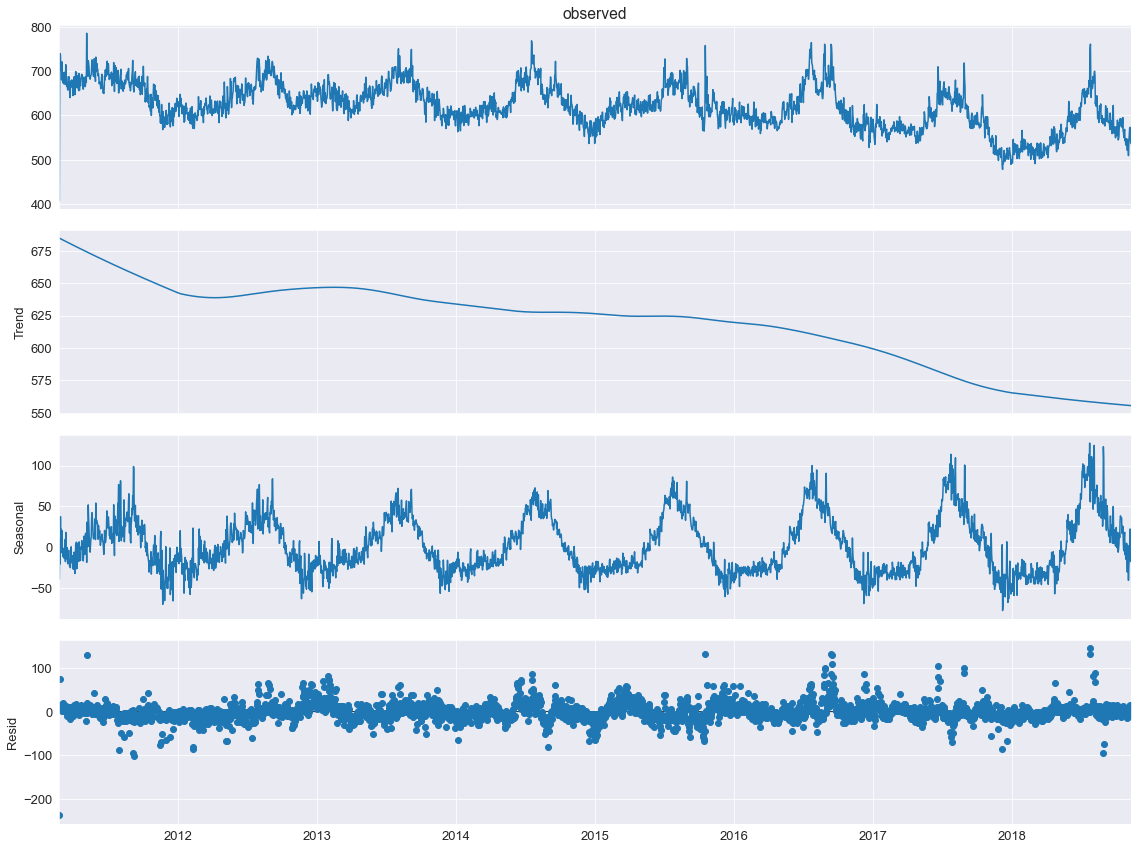

In [36]:
mstl = MSTL(df["activity"], periods=[365], stl_kwargs = {"robust":True})
res = mstl.fit()
ax = res.plot()

In [38]:
mstl = MSTL(df["activity"], stl_kwargs = {"robust":True, "period" : None})
res = mstl.fit()
ax = res.plot()

ValueError: Unable to determine period from endog

In [44]:
from statsmodels.tsa.seasonal import STL
df.index = [i for i in range(df.shape[0])]
res = STL(df["activity"], period=None).fit()
res.plot()
plt.show()

ValueError: Unable to determine period from endog

In [42]:
print(df)

        activity
0     407.290000
1     704.828571
2     739.716981
3     736.650943
4     702.028302
...          ...
2812  570.818182
2813  573.190000
2814  550.190476
2815  538.090090
2816  536.099099

[2817 rows x 1 columns]
